# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

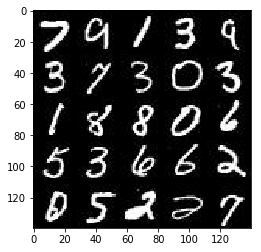

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

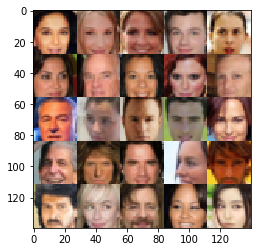

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Helpers

I wrote these to remove the deplicated code from all over the place and reduce copy-paste errors

In [6]:
def lrelu(tensor, alpha=0.2):
    """Calculate a leaky ReLU with the supplied tensor and alpha"""
    return tf.maximum(tensor, tensor * alpha)

In [7]:
def conv2d_leaky(inputs, outputs, kernel_size=5, strides=2, padding='same', alpha=0.2):
    layer = tf.layers.conv2d(inputs, outputs, kernel_size, strides, padding)
    return lrelu(layer, alpha) if alpha != -1 else layer

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    keep_prob = 0.8

    # image shape: batch_count, 28, 28, 3
    with tf.variable_scope('discriminator', reuse=reuse):
        
        conv0 = conv2d_leaky(images, 32, strides=1, padding='same')
        conv0 = tf.nn.dropout(conv0, keep_prob)
        
        conv1 = conv2d_leaky(images, 64, strides=2, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=False)
        conv1 = tf.nn.dropout(conv1, keep_prob)
        # now 14x14x64

        conv2 = conv2d_leaky(conv1, 128)
        conv2 = tf.layers.batch_normalization(conv2, training=False)
        conv2 = tf.nn.dropout(conv2, keep_prob)
        # now 7x7x128
                
        conv3 = conv2d_leaky(conv2, 256, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=False)
        conv3 = tf.nn.dropout(conv3, keep_prob)
        # now 4x4x256
        
        conv4 = conv2d_leaky(conv3, 512, strides=1, padding='same')
        conv4 = tf.layers.batch_normalization(conv4, training=False)
        conv4 = tf.nn.dropout(conv4, keep_prob)
        
        
        flat = tf.reshape(conv4, (-1, 2 * 2 * 512))
        
        logits = tf.layers.dense(flat, 1)
        out = tf.nn.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # notes to self:
    keep_prob = 0.8 # this is the default of tf.layers.dropout and a "first attempt guess"
    # we can set alpha later
    
    # why the opposite???
    with tf.variable_scope('generator', reuse=not is_train):

        x1 = tf.layers.dense(z, 7 * 7 * 512,
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        

        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = lrelu(x1)
        # 7x7x512 now

        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                        batch_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = lrelu(x2)
        x2 = tf.layers.dropout(x2, keep_prob)
        # 14x14x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                        batch_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = lrelu(x3)
        x3 = tf.layers.dropout(x3, keep_prob)
        # 28x28x128 now
        
        
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=1, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                        batch_initializer=tf.contrib.layers.xavier_initializer())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = lrelu(x4)
        x4 = tf.layers.dropout(x4, keep_prob)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                            batch_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # encapsulate the repeated logic
    def model_loss(logits, like_shape_for_labels, smoothing=1):
        return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=like_shape_for_labels))
    
    smoothing = 0.9 # factor to help with generalization
    
    # now actually calculate those losses
    d_loss_real = model_loss(d_logits_real, tf.ones_like(d_model_real) * smoothing)

    d_loss_fake = model_loss(d_logits_fake, tf.zeros_like(d_model_fake))
    g_loss = model_loss(d_logits_fake, tf.ones_like(d_model_fake))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainables = tf.trainable_variables()
    d_vars = [var for var in trainables if var.name.startswith('discriminator')]
    g_vars = [var for var in trainables if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    print("parameters:")
    print("\t epoch_count =", epoch_count)
    print("\t batch_size =", batch_size)
    print("\t z_dim =", z_dim)
    print("\t learning_rate =", learning_rate)
    print("\t beta1 =", beta1)
    print("\t data_shape =", data_shape)
    print("\t image_mode =", data_image_mode)
    
    data_set_size, width, height, channels = data_shape
    
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    step = 0
    print_every = 25
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Optimizers do their thing
                _ = sess.run(d_opt, feed_dict={ input_z: batch_z, input_real: batch_images, lr: learning_rate })

                # double dip for the Generator, see if it addresses the symptoms
                for _ in range(0, 2):
                    _ = sess.run(g_opt, feed_dict={ input_z: batch_z, input_real: batch_images, lr: learning_rate })
                
                if step % print_every == 0:
                    train_loss_d = d_loss.eval({ input_z: batch_z, input_real: batch_images })
                    train_loss_g = g_loss.eval({ input_z: batch_z })

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if step % show_every == 0:
                    show_generator_output(sess, 10, input_z, channels, data_image_mode)

    # No return value because we are just churning on the data

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

parameters:
	 epoch_count = 2
	 batch_size = 64
	 z_dim = 100
	 learning_rate = 0.0002
	 beta1 = 0.5
	 data_shape = (60000, 28, 28, 1)
	 image_mode = L
Epoch 1/2... Discriminator Loss: 1.2802... Generator Loss: 1.3114
Epoch 1/2... Discriminator Loss: 1.3421... Generator Loss: 0.7741
Epoch 1/2... Discriminator Loss: 1.3368... Generator Loss: 0.6549
Epoch 1/2... Discriminator Loss: 1.3767... Generator Loss: 0.7231


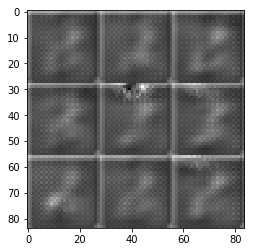

Epoch 1/2... Discriminator Loss: 1.2274... Generator Loss: 1.2215
Epoch 1/2... Discriminator Loss: 1.4814... Generator Loss: 0.7062
Epoch 1/2... Discriminator Loss: 1.3289... Generator Loss: 0.8594
Epoch 1/2... Discriminator Loss: 1.3705... Generator Loss: 0.7962


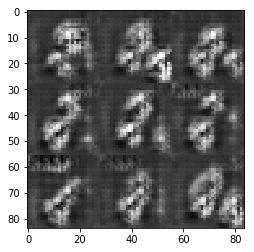

Epoch 1/2... Discriminator Loss: 1.3277... Generator Loss: 0.9640
Epoch 1/2... Discriminator Loss: 1.5756... Generator Loss: 0.5520
Epoch 1/2... Discriminator Loss: 1.2305... Generator Loss: 1.0476
Epoch 1/2... Discriminator Loss: 1.1860... Generator Loss: 0.7676


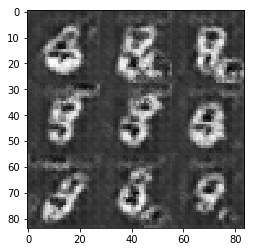

Epoch 1/2... Discriminator Loss: 1.2710... Generator Loss: 0.8247
Epoch 1/2... Discriminator Loss: 1.3339... Generator Loss: 0.5836
Epoch 1/2... Discriminator Loss: 0.8293... Generator Loss: 1.4565
Epoch 1/2... Discriminator Loss: 1.4949... Generator Loss: 0.5888


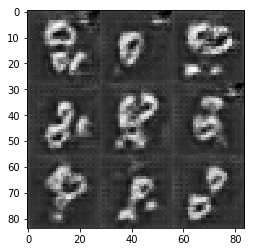

Epoch 1/2... Discriminator Loss: 1.3066... Generator Loss: 0.8472
Epoch 1/2... Discriminator Loss: 1.4092... Generator Loss: 0.6034
Epoch 1/2... Discriminator Loss: 0.7854... Generator Loss: 1.9773
Epoch 1/2... Discriminator Loss: 0.7674... Generator Loss: 1.9785


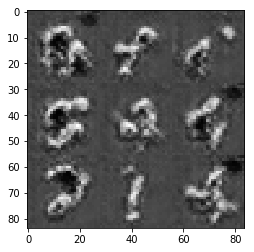

Epoch 1/2... Discriminator Loss: 1.0361... Generator Loss: 5.8541
Epoch 1/2... Discriminator Loss: 1.1195... Generator Loss: 1.0134
Epoch 1/2... Discriminator Loss: 1.2353... Generator Loss: 0.7286
Epoch 1/2... Discriminator Loss: 1.1020... Generator Loss: 1.2423


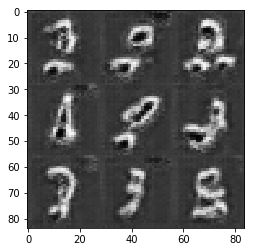

Epoch 1/2... Discriminator Loss: 0.6013... Generator Loss: 3.1171
Epoch 1/2... Discriminator Loss: 0.9643... Generator Loss: 1.3714
Epoch 1/2... Discriminator Loss: 1.2530... Generator Loss: 1.1285
Epoch 1/2... Discriminator Loss: 1.1099... Generator Loss: 1.2638


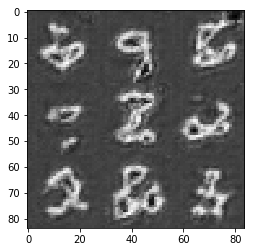

Epoch 1/2... Discriminator Loss: 0.9192... Generator Loss: 1.1482
Epoch 1/2... Discriminator Loss: 0.9391... Generator Loss: 1.3096
Epoch 1/2... Discriminator Loss: 1.2735... Generator Loss: 2.0843
Epoch 1/2... Discriminator Loss: 1.1906... Generator Loss: 0.9582


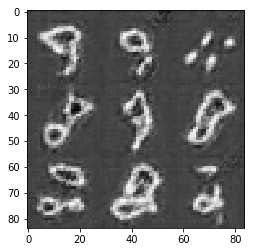

Epoch 1/2... Discriminator Loss: 0.8858... Generator Loss: 1.9650
Epoch 1/2... Discriminator Loss: 0.9523... Generator Loss: 1.8046
Epoch 1/2... Discriminator Loss: 0.5879... Generator Loss: 6.5841
Epoch 1/2... Discriminator Loss: 0.9753... Generator Loss: 1.6429


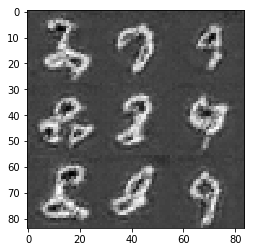

Epoch 1/2... Discriminator Loss: 1.0478... Generator Loss: 1.2364
Epoch 2/2... Discriminator Loss: 0.9135... Generator Loss: 1.8999
Epoch 2/2... Discriminator Loss: 1.1812... Generator Loss: 1.0373
Epoch 2/2... Discriminator Loss: 1.3080... Generator Loss: 0.8026


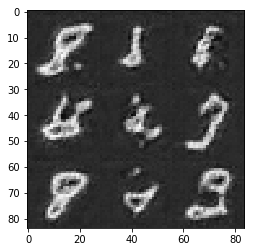

Epoch 2/2... Discriminator Loss: 1.0154... Generator Loss: 1.1185
Epoch 2/2... Discriminator Loss: 0.8765... Generator Loss: 2.1876
Epoch 2/2... Discriminator Loss: 1.1240... Generator Loss: 0.8962
Epoch 2/2... Discriminator Loss: 1.1522... Generator Loss: 1.2939


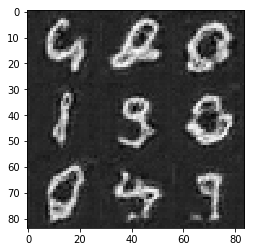

Epoch 2/2... Discriminator Loss: 1.1128... Generator Loss: 0.7933
Epoch 2/2... Discriminator Loss: 1.0777... Generator Loss: 1.0339
Epoch 2/2... Discriminator Loss: 1.0369... Generator Loss: 1.3413
Epoch 2/2... Discriminator Loss: 0.9489... Generator Loss: 1.3223


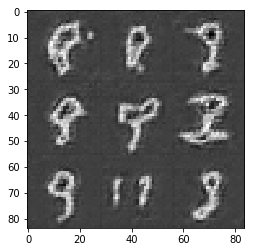

Epoch 2/2... Discriminator Loss: 0.5816... Generator Loss: 2.3826
Epoch 2/2... Discriminator Loss: 1.0370... Generator Loss: 1.2705
Epoch 2/2... Discriminator Loss: 0.8506... Generator Loss: 2.7781
Epoch 2/2... Discriminator Loss: 1.0327... Generator Loss: 1.6095


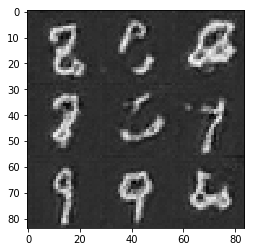

Epoch 2/2... Discriminator Loss: 1.1833... Generator Loss: 0.9757
Epoch 2/2... Discriminator Loss: 1.2398... Generator Loss: 0.7404
Epoch 2/2... Discriminator Loss: 1.1503... Generator Loss: 1.1891
Epoch 2/2... Discriminator Loss: 0.9989... Generator Loss: 1.9446


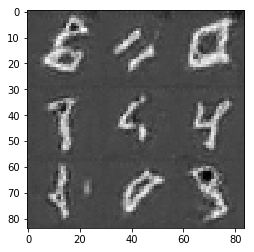

Epoch 2/2... Discriminator Loss: 1.1079... Generator Loss: 0.8515
Epoch 2/2... Discriminator Loss: 1.1167... Generator Loss: 1.3196
Epoch 2/2... Discriminator Loss: 1.1996... Generator Loss: 1.0128
Epoch 2/2... Discriminator Loss: 1.1479... Generator Loss: 1.1128


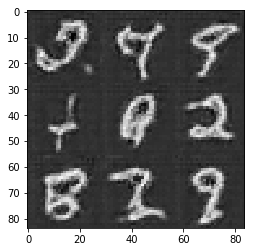

Epoch 2/2... Discriminator Loss: 1.2194... Generator Loss: 0.8082
Epoch 2/2... Discriminator Loss: 1.3583... Generator Loss: 0.6518
Epoch 2/2... Discriminator Loss: 1.1732... Generator Loss: 0.7883
Epoch 2/2... Discriminator Loss: 1.0416... Generator Loss: 1.1791


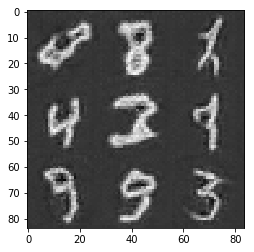

Epoch 2/2... Discriminator Loss: 1.0224... Generator Loss: 0.8830
Epoch 2/2... Discriminator Loss: 1.1757... Generator Loss: 0.8901
Epoch 2/2... Discriminator Loss: 1.1015... Generator Loss: 1.3282
Epoch 2/2... Discriminator Loss: 1.0936... Generator Loss: 1.0513


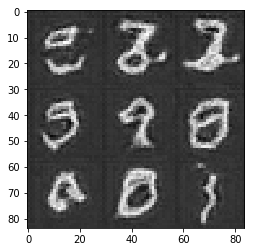

Epoch 2/2... Discriminator Loss: 1.0822... Generator Loss: 1.5092
Epoch 2/2... Discriminator Loss: 1.3015... Generator Loss: 2.5140
Epoch 2/2... Discriminator Loss: 1.0829... Generator Loss: 1.0659
Epoch 2/2... Discriminator Loss: 1.2415... Generator Loss: 1.6876


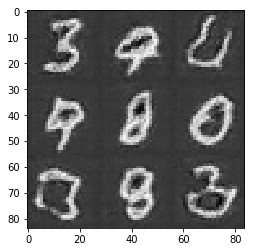

Epoch 2/2... Discriminator Loss: 1.2118... Generator Loss: 0.9256
Epoch 2/2... Discriminator Loss: 1.1609... Generator Loss: 1.0146


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

parameters:
	 epoch_count = 1
	 batch_size = 32
	 z_dim = 100
	 learning_rate = 0.0002
	 beta1 = 0.8
	 data_shape = (202599, 28, 28, 3)
	 image_mode = RGB
Epoch 1/1... Discriminator Loss: 0.6310... Generator Loss: 4.8782
Epoch 1/1... Discriminator Loss: 0.7028... Generator Loss: 4.4843
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 2.6575
Epoch 1/1... Discriminator Loss: 0.8868... Generator Loss: 1.1143


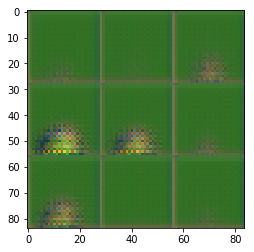

Epoch 1/1... Discriminator Loss: 0.8213... Generator Loss: 1.6983
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.6091... Generator Loss: 0.6295


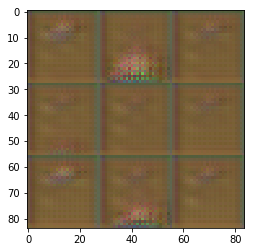

Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 0.8708


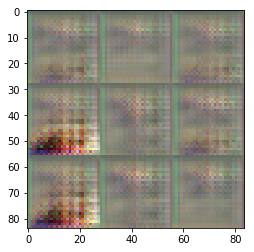

Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.9128
Epoch 1/1... Discriminator Loss: 1.7199... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.9276


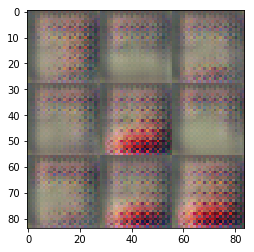

Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 1.0219
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.8045


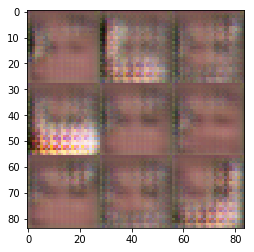

Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.8786
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.8276
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.7961


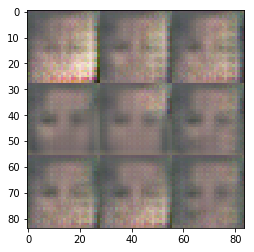

Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 1.0301
Epoch 1/1... Discriminator Loss: 1.4625... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.7562


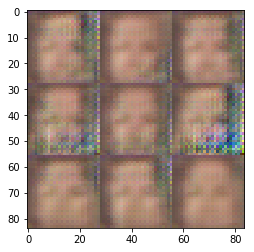

Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.7996
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.9603


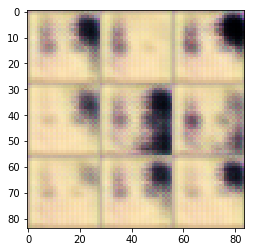

Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.8224
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.7089


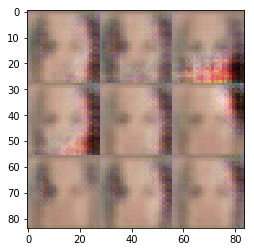

Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.8300
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.8192


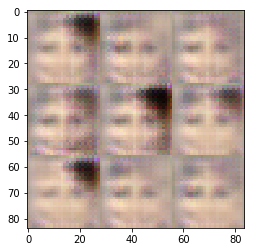

Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7868


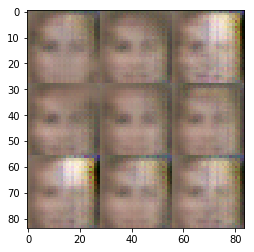

Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.9276
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.8076


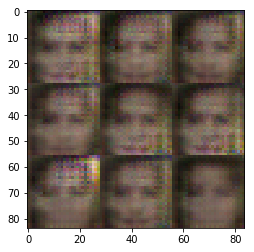

Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.4798... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.9336


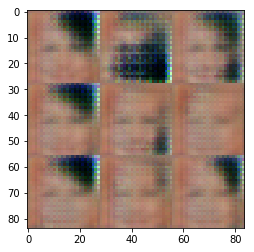

Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.8120


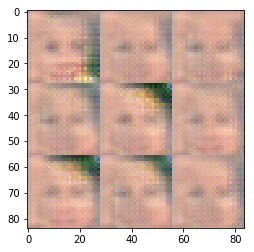

Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.8262


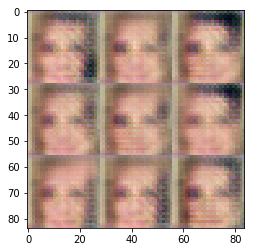

Epoch 1/1... Discriminator Loss: 1.9221... Generator Loss: 0.3426
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.4207... Generator Loss: 0.7986


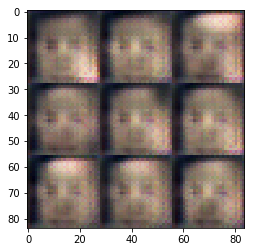

Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.8357


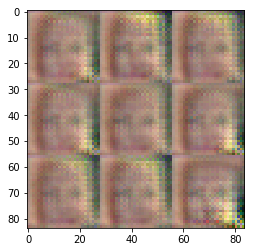

Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.8277


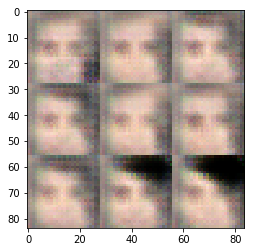

Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.9755
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.8350


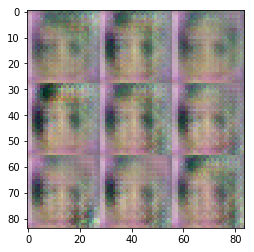

Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.7897


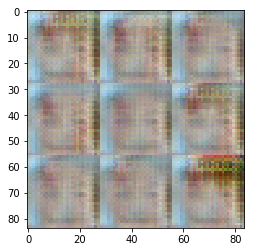

Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7797


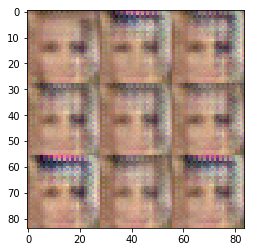

Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.8064


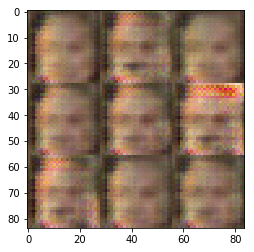

Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.8106


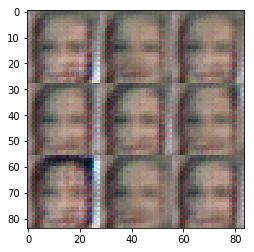

Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.8155


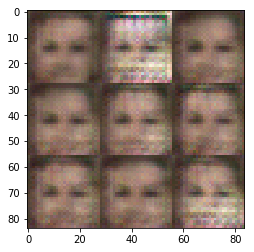

Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.7625


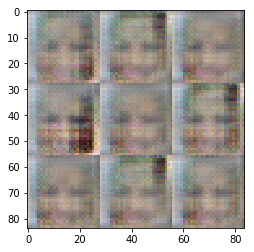

Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7893


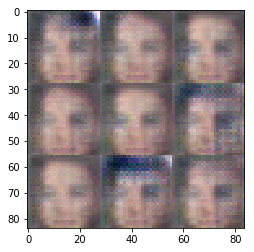

Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7375


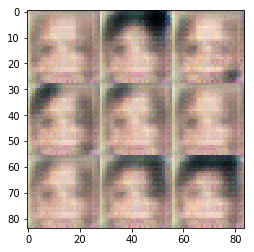

Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7933
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7590


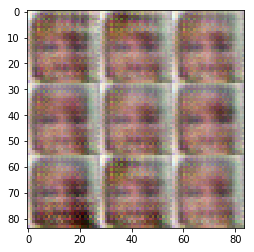

Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 1.3652


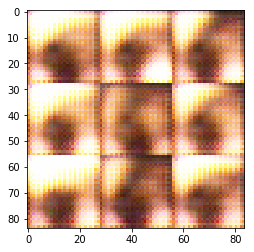

Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 1.0694


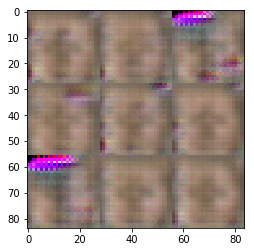

Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.9790


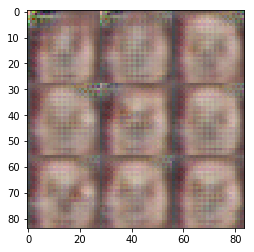

Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.8446


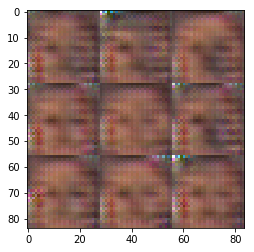

Epoch 1/1... Discriminator Loss: 1.4020... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 1.5738... Generator Loss: 0.5325
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.5613


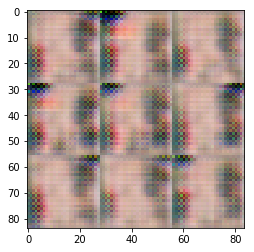

Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.9706


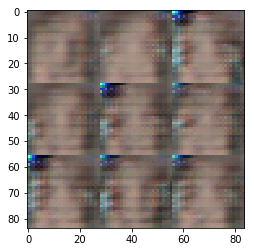

Epoch 1/1... Discriminator Loss: 1.5254... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.8840
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.8171


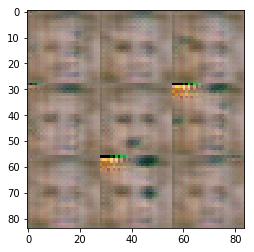

Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 0.9401... Generator Loss: 1.1527
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.9758
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.6535


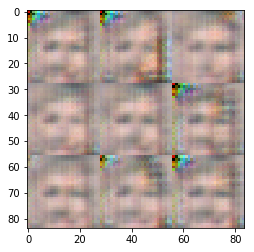

Epoch 1/1... Discriminator Loss: 1.5437... Generator Loss: 0.8791
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 1.1910
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 0.9960


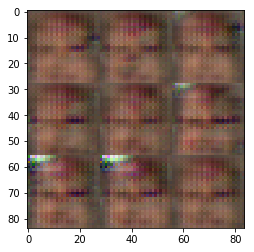

Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 1.0020
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 1.2826
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.8479
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.7144


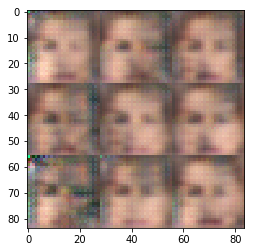

Epoch 1/1... Discriminator Loss: 1.1792... Generator Loss: 0.9961
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 1.0446
Epoch 1/1... Discriminator Loss: 1.6617... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7996


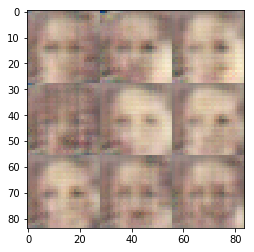

Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.8921
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.5797... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.8460


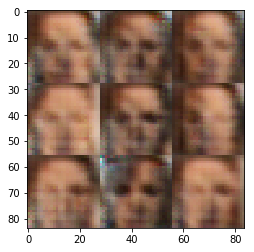

Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.9789... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.8172


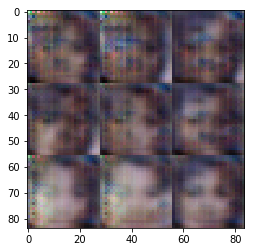

Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.9639
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 1.1987
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 1.0278


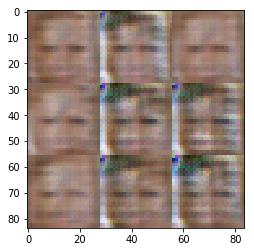

Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.9247... Generator Loss: 0.4367
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.8292


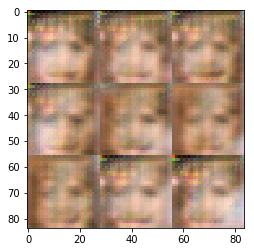

Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.8931
Epoch 1/1... Discriminator Loss: 1.3228... Generator Loss: 1.0431
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 1.0530


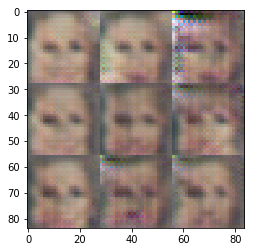

Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 1.0875
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.8909


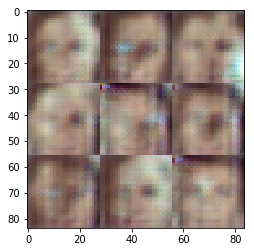

Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.5649... Generator Loss: 0.7828


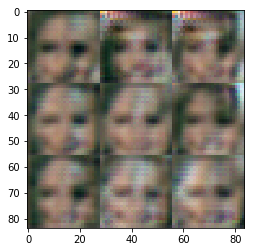

Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.5646... Generator Loss: 0.7389
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.6878


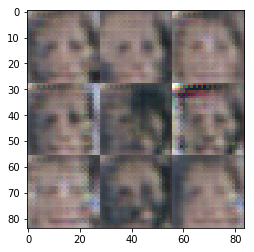

Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.8014


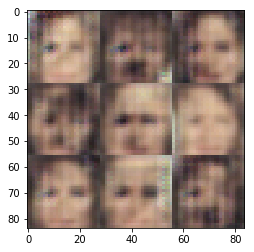

Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.6529... Generator Loss: 0.9076
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.7767


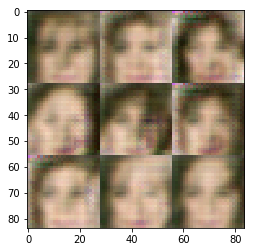

Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.5365... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 1.0013


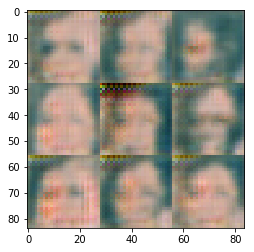

Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.8302
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.9058


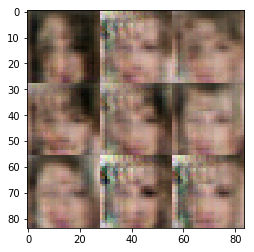

Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.8776
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.9055


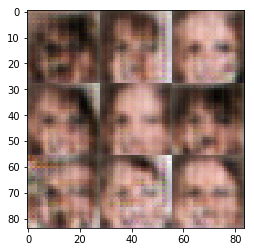

Epoch 1/1... Discriminator Loss: 1.4370... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.8617
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.9622


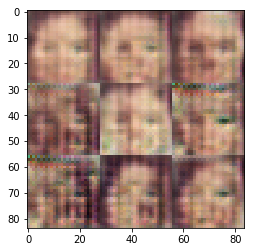

Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 1.0787


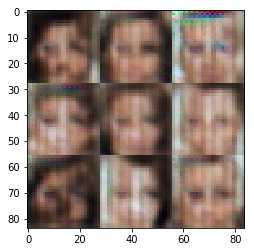

Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.7367... Generator Loss: 1.0413
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 1.1055


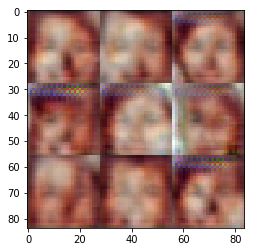

Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.8631


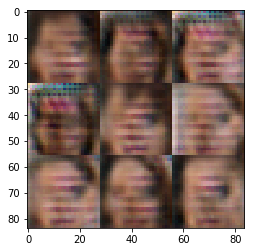

Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.1678... Generator Loss: 0.8896
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 1.5710... Generator Loss: 0.8218


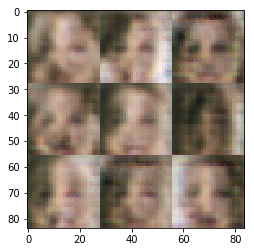

Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.5274... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 0.8422


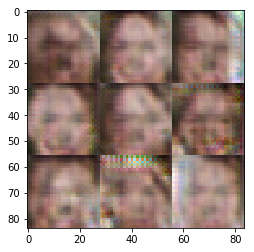

Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 1.1987
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 1.0014
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.8020


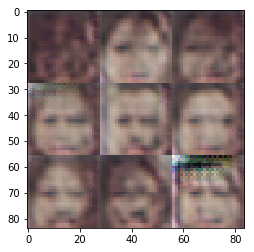

Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 1.0868
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.8792


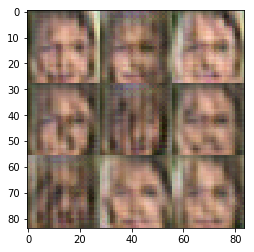

Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 1.1005
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.8761


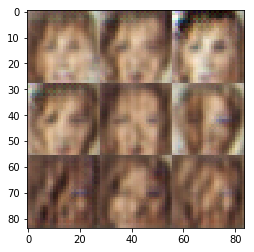

Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.9618
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.8190


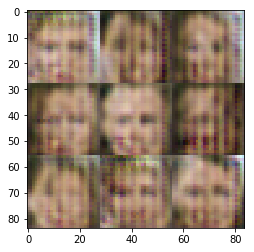

Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 1.1037
Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.5723... Generator Loss: 0.9772


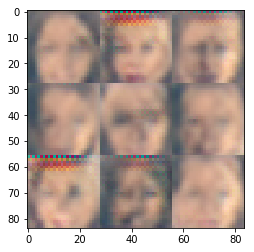

Epoch 1/1... Discriminator Loss: 1.7317... Generator Loss: 0.7808


In [15]:
batch_size = 32 # see slack #project-5
z_dim = 100
learning_rate = 0.0002
beta1 = 0.8


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.